1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from datetime import datetime

2. Load Dataset

In [2]:
df = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
print("Jumlah baris & kolom:", df.shape)
df.head()

Jumlah baris & kolom: (525461, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


3. Data Cleaning

In [3]:
df.dropna(subset=["Customer ID"], inplace=True)

In [4]:
df.drop_duplicates(inplace=True)

In [5]:
print("Transaksi Quantity negatif:", (df['Quantity'] <= 0).sum())
print("Transaksi Price negatif:", (df['Price'] <= 0).sum())

Transaksi Quantity negatif: 9816
Transaksi Price negatif: 31


In [6]:
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

In [7]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [8]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

print("Data setelah dibersihkan:", df.shape)

Data setelah dibersihkan: (400916, 9)


4. EDA (Exploratory Data Analysis)

In [9]:
print("\nJumlah pelanggan unik:", df["Customer ID"].nunique())
print("Jumlah produk unik:", df["Description"].nunique())
print("Total penjualan:", df["TotalPrice"].sum())


Jumlah pelanggan unik: 4312
Jumlah produk unik: 4444
Total penjualan: 8798233.743999999


/tmp/ipython-input-3344547600.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_products.index, x=top_products.values, palette="viridis")


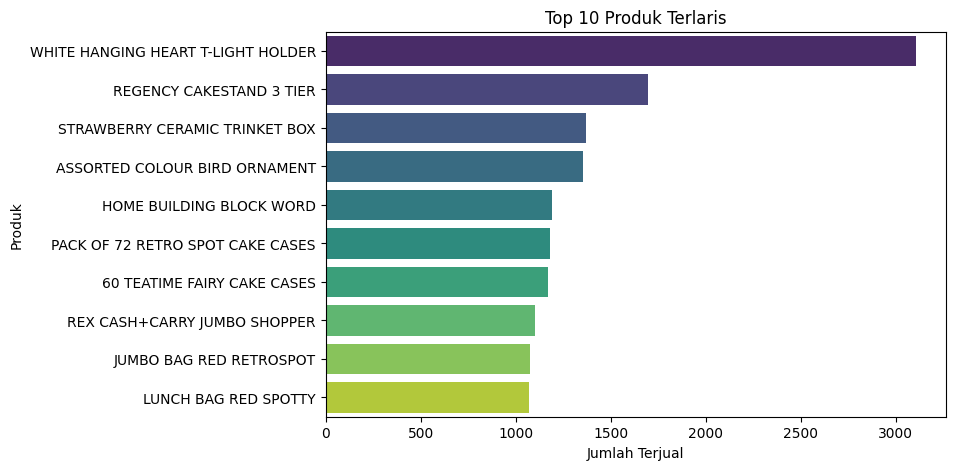

In [10]:
top_products = df["Description"].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(y=top_products.index, x=top_products.values, palette="viridis")
plt.title("Top 10 Produk Terlaris")
plt.xlabel("Jumlah Terjual")
plt.ylabel("Produk")
plt.show()

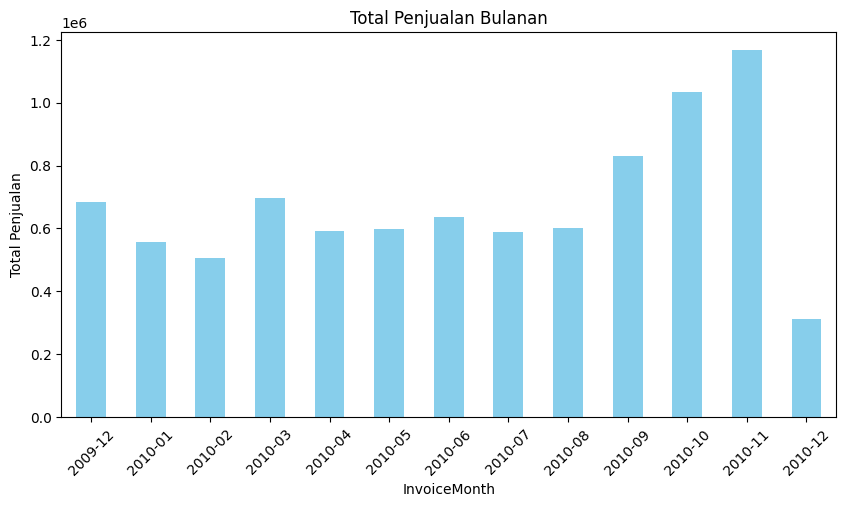

In [11]:
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")
monthly_sales = df.groupby("InvoiceMonth")["TotalPrice"].sum()
plt.figure(figsize=(10,5))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title("Total Penjualan Bulanan")
plt.ylabel("Total Penjualan")
plt.xticks(rotation=45)
plt.show()

5. Perhitungan RFM

In [12]:
ref_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,  # Recency
    "Invoice": "nunique",                                # Frequency
    "TotalPrice": "sum"                                  # Monetary
}).reset_index()

rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

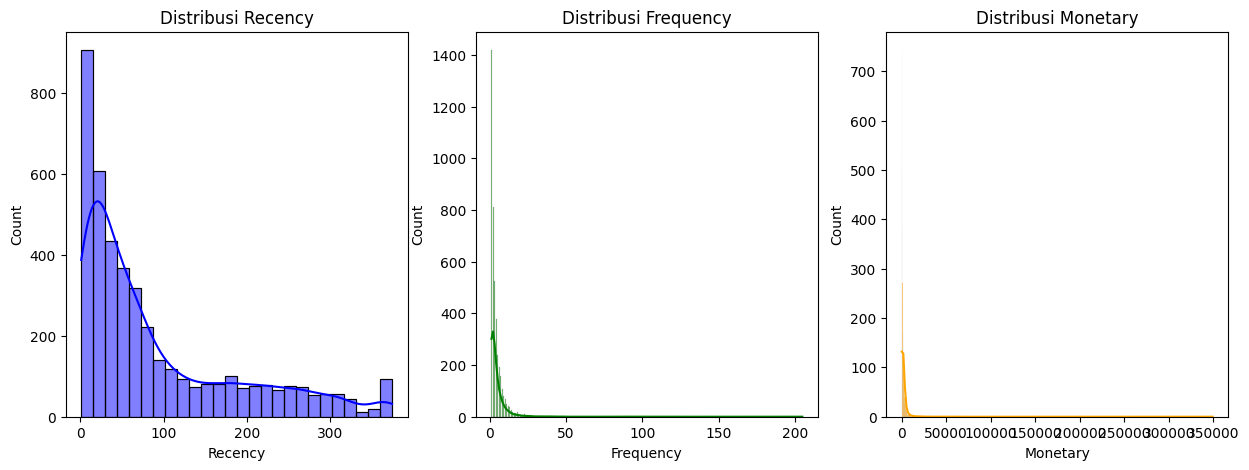

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.histplot(rfm["Recency"], kde=True, ax=axes[0], color='blue')
sns.histplot(rfm["Frequency"], kde=True, ax=axes[1], color='green')
sns.histplot(rfm["Monetary"], kde=True, ax=axes[2], color='orange')
axes[0].set_title("Distribusi Recency")
axes[1].set_title("Distribusi Frequency")
axes[2].set_title("Distribusi Monetary")
plt.show()

6. Normalisasi Data

In [14]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

7. Tentukan Jumlah Cluster (Elbow & Silhouette)

In [15]:
wcss = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

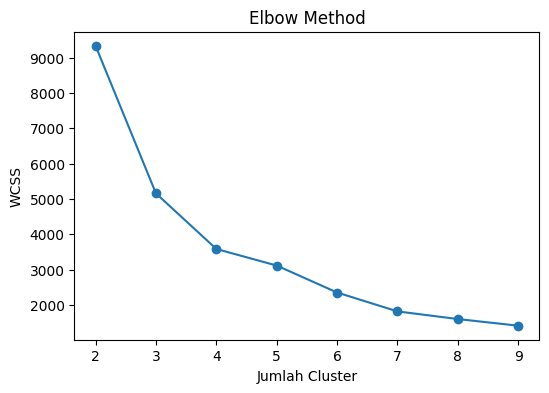

In [16]:
plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Jumlah Cluster")
plt.ylabel("WCSS")
plt.show()

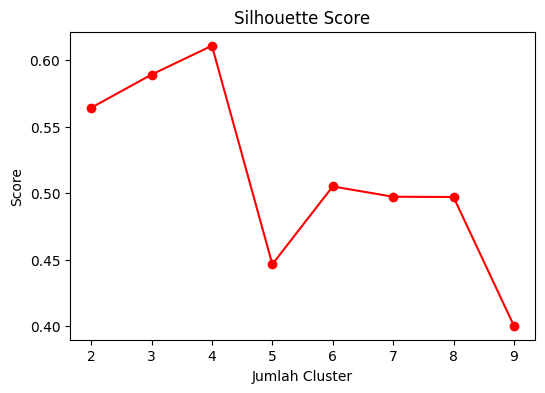

In [17]:
plt.figure(figsize=(6,4))
plt.plot(K_range, silhouette_scores, marker='o', color='red')
plt.title("Silhouette Score")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Score")
plt.show()

8. K-Means Clustering

In [18]:
optimal_k = 4  # misalnya dari hasil elbow & silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


9. Analisis Cluster

In [19]:
cluster_summary = rfm.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": ["mean", "count"]
}).round(1)

print("\nRingkasan Tiap Cluster:")
print(cluster_summary)


Ringkasan Tiap Cluster:
        Recency Frequency  Monetary      
           mean      mean      mean count
Cluster                                  
0          43.0       4.5    1710.7  3204
1         243.0       1.7     593.5  1047
2           5.6     113.6  215535.0     5
3          14.9      47.0   28896.4    56


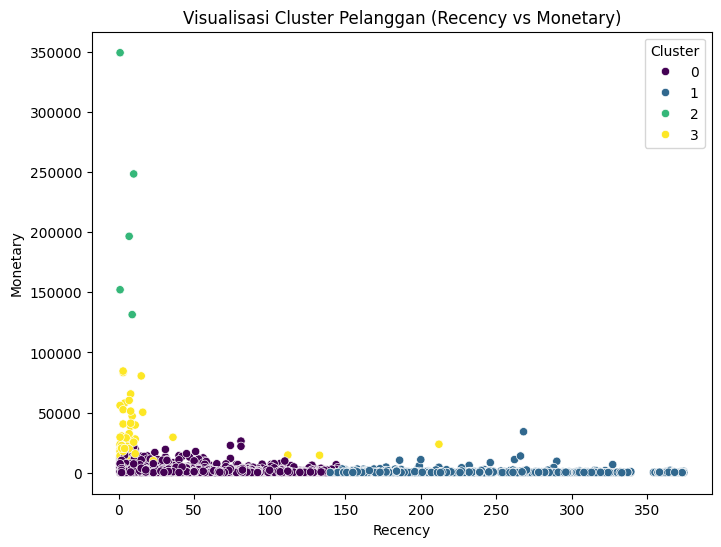

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="viridis")
plt.title("Visualisasi Cluster Pelanggan (Recency vs Monetary)")
plt.show()

10. Label Segmentasi (Contoh)

In [21]:
segment_labels = {
    0: "Best Customers",
    1: "Loyal Customers",
    2: "At Risk",
    3: "Low Value"
}
rfm["Segment"] = rfm["Cluster"].map(segment_labels)

/tmp/ipython-input-4240778279.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x="Segment", order=segment_labels.values(), palette="coolwarm")


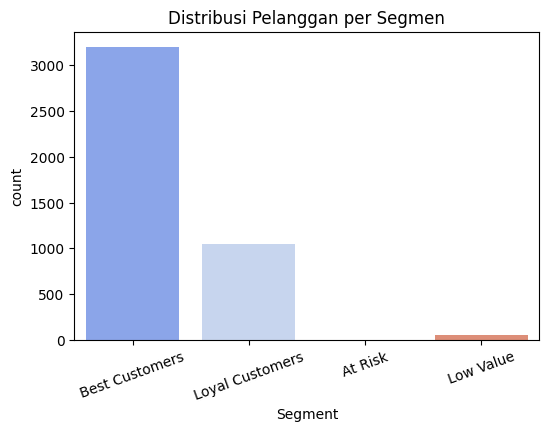

In [22]:
plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x="Segment", order=segment_labels.values(), palette="coolwarm")
plt.title("Distribusi Pelanggan per Segmen")
plt.xticks(rotation=20)
plt.show()

11. Insight & Rekomendasi Bisnis

In [23]:
for seg in rfm["Segment"].unique():
    cust_count = rfm[rfm["Segment"] == seg].shape[0]
    print(f"\nSegmen: {seg}")
    print(f"Jumlah pelanggan: {cust_count}")
    if seg == "Best Customers":
        print("Strategi: Berikan reward & loyalty program untuk mempertahankan mereka.")
    elif seg == "Loyal Customers":
        print("Strategi: Berikan diskon rutin & penawaran produk baru.")
    elif seg == "At Risk":
        print("Strategi: Kirim email promo & reminder untuk menarik kembali mereka.")
    elif seg == "Low Value":
        print("Strategi: Gunakan promo kecil untuk meningkatkan pembelian.")


Segmen: Loyal Customers
Jumlah pelanggan: 1047
Strategi: Berikan diskon rutin & penawaran produk baru.

Segmen: Best Customers
Jumlah pelanggan: 3204
Strategi: Berikan reward & loyalty program untuk mempertahankan mereka.

Segmen: Low Value
Jumlah pelanggan: 56
Strategi: Gunakan promo kecil untuk meningkatkan pembelian.

Segmen: At Risk
Jumlah pelanggan: 5
Strategi: Kirim email promo & reminder untuk menarik kembali mereka.
